# A Guide to Time Series Forecasting with ARIMA in Python 3

* Ref: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
* Data: 使用 statsmodels 內自帶的資料集
  * Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display

In [47]:
import numpy as np
import statsmodels.api as sm
import warnings
import itertools

## 1. Load data

In [48]:
data = sm.datasets.co2.load_pandas()
df = data.data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


* 資料是 weekly 的，把它改成 monthly 的
  * 用每個月的第一天當作日期 $\rightarrow$ `resample()` 的參數用 `MS`
  * 用每個月的平均值 $\rightarrow$ aggregation function 用 `mean()`
* 資料有 missing values 所以要做 missing value imputation
  * 用 backward fill `bfill()`: 就是用最接近的後面的非零值來填補前面的缺失值

In [50]:
s = df['co2'].resample('MS').mean()

if s.isnull().sum() > 0:
  print('Doing missing value imputation')
  s = s.fillna(s.bfill())

s.head()

Doing missing value imputation


1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

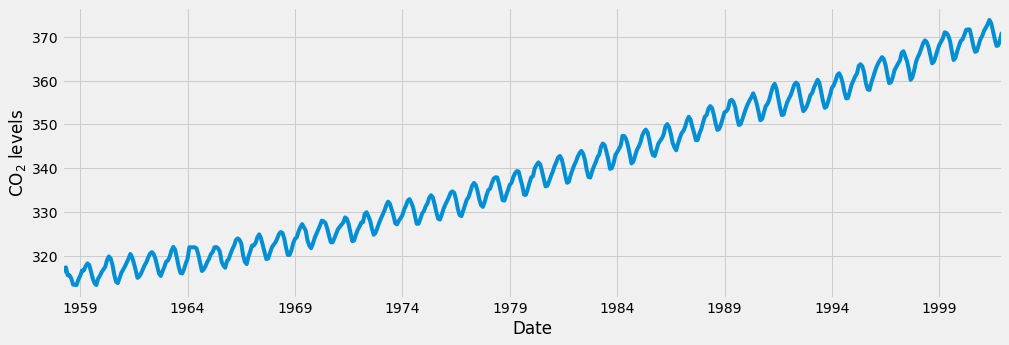

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))
s.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('CO$_{2}$ levels')
plt.show()

## 2. Analysis
* 檢查是否有 bias
    * 1 sample student test
      * null hypothesis: there is no effective difference between the observed sample mean and the hypothesized or stated population mean—i.e., that any measured difference is due only to chance. 
      * 就是說 sample mean = population mean
* 檢查是否有 autocorrelation
    * Ljung-Box test
    * 畫圖
* 檢查是否是 stationary
    * Dickey-Fuller test
      * null hypothesis: time series 是 non-stationary 的
      * Test statistics  <  critical value  →  reject null hypothesis
      * $p$ -value  <  0.05  →  reject null hypothesis
      * ADF < 0 (ADF 就是 test statistics)
* 做 seasonal decomposition

In [52]:
def student_test(time_series):
    # perform 1 sample student test
    # null hypothesis: sample mean = population mean
    from scipy import stats

    student_test = stats.ttest_1samp(time_series, 0)[1]
    print(f"Students' criterion: p={student_test}")

    if student_test < 0.05:
        print('Because p < 0.05, we reject the null hypothesis.')
        print('--> The sample mean is not equal to population mean.\n')

In [53]:
def adf_test(time_series):
    # perform Dickey-Fuller test
    # null hypothesis: the time series is non-stationary 
    from statsmodels.tsa.stattools import adfuller # Use augmented dickey-fuller test to check stationality

    print('Results of Dickey-Fuller test:')
    adf_test = adfuller(time_series, autolag='AIC') # AIC: Akaike information criterion (AIC), the smaller AIC the better model

    index = [
      'Test statistics (ADF)',
      'p-value',
      'Number of lags used',
      'Number of observations used'
    ]
    adf_results = pd.Series(adf_test[:4], index=index)

    for k, v in adf_test[4].items():
        adf_results[f'Critical value ({k})'] = v

    print(adf_results)

    if adf_results[1] <= 0.05:
        print('Because p <= 0.05, we reject the null hypothesis')
        print('--> The time series is stationary')
    else:
        print('-->The time series is non-stationary')

In [54]:
def check_time_series(time_series, window=12, bias=True, adf=True):
  # determin rolling statistics
  rolling_mean = time_series.rolling(window).mean()
  rolling_std = time_series.rolling(window).std()

  # plot rolling statistics
  fig, ax = plt.subplots(figsize=(15, 5))
  time_series.plot(ax=ax, color='blue', label='original')
  rolling_mean.plot(ax=ax, color='red', label='rolling mean')
  rolling_std.plot(ax=ax, color='black', label='rolling std')
  plt.legend()
  plt.xlabel('Date')
  plt.title('Rolling mean and standard deviation')
  plt.show()

  # perform 1 sample student test
  # null hypothesis: sample mean = population mean
  if bias:
    student_test(time_series)

  # perform Dickey-Fuller test
  # null hypothesis: the time series is non-stationary
  if adf:
    adf_test(time_series)

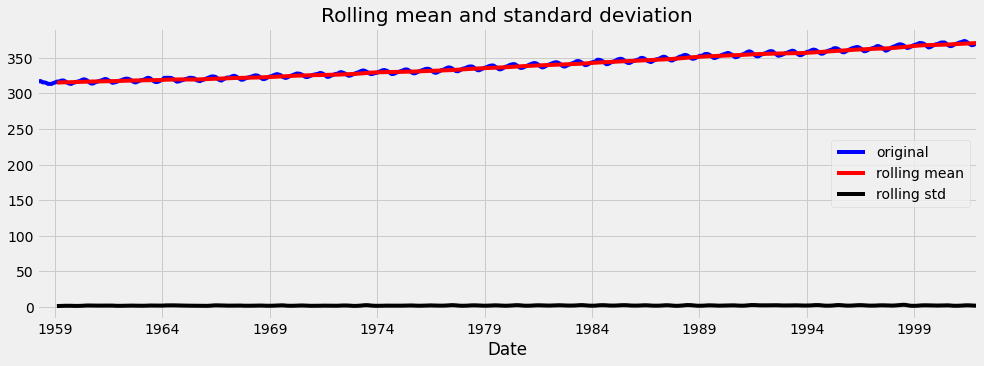

Students' criterion: p=0.0
Because p < 0.05, we reject the null hypothesis.
--> The sample mean is not equal to population mean.

Results of Dickey-Fuller test:
Test statistics (ADF)            2.359810
p-value                          0.998990
Number of lags used             14.000000
Number of observations used    511.000000
Critical value (1%)             -3.443212
Critical value (5%)             -2.867213
Critical value (10%)            -2.569791
dtype: float64
-->The time series is non-stationary


In [55]:
check_time_series(s, 12)

* Student's test $p$-value < 0.05 $\rightarrow$ reject null hypothesis
  * There are difference between sample mean and population mean.
* Dickey-Fuller test $p$-value > 0.05 $\rightarrow$ not reject null hypothesie
  * This time series is non-stationary
  * Need to apply differencing to make the time series stationary

In [56]:
# 用已有的函數畫圖
def plot_lags_autocorrelation_acf_pacf(time_series, nlags=50): # 只畫前 50 個 lags
  fig, ax = plt.subplots(2, 2, figsize=(18, 8))
  # 畫 lag_plot(), autocorrelation_plot()
  pd.plotting.lag_plot(time_series, ax=ax[0][0])
  pd.plotting.autocorrelation_plot(time_series, ax=ax[0][1])

  # 畫 plot_acf(), plot_pacf()
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  plot_acf(time_series, lags=nlags, ax=ax[1][0]) 
  plot_pacf(time_series, lags=nlags, ax=ax[1][1])

  plt.tight_layout()
  plt.show()

# 自己手動計算 ACF 和 PACF 然後畫圖
def plot_calculated_acf_and_pacf(time_series, nlags=50): # 只畫前 50 個 lags
  import numpy as np
  from statsmodels.tsa.stattools import acf, pacf
  lag_acf = acf(time_series, nlags=nlags)
  lag_pacf = pacf(time_series, nlags=nlags, method='ols') # OLS: ordinary least square

  fig, ax = plt.subplots(1, 2, figsize=(18, 4))
  ax[0].plot(lag_acf)
  ax[0].axhline(y=0, linestyle='--', color='gray')
  ax[0].axhline(y=-1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[0].axhline(y=1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[0].set_title('Autocorrelation Function')

  ax[1].plot(lag_pacf)
  ax[1].axhline(y=0, linestyle='--', color='gray')
  ax[1].axhline(y=-1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[1].axhline(y=1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[1].set_title('Partical Autocorrelation Function')

  plt.tight_layout()
  plt.show()

def plot_seasonal_decomposition(time_series, model): # model=additive or multiplicative
  from statsmodels.tsa.seasonal import seasonal_decompose
  decomposition = seasonal_decompose(time_series, model=model)
  # 只畫一張圖，會很小，都擠在一起
  # fig = decomposition.plot()

  # 改成單獨畫每張圖
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  fig, ax = plt.subplots(3, 1, figsize=(18, 9))
  trend.plot(ax=ax[0])
  ax[0].set_ylabel('Trend')

  seasonal.plot(ax=ax[1])
  ax[1].set_ylabel('Seasonal')

  residual.plot(ax=ax[2])
  ax[2].set_ylabel('Residual')

  plt.tight_layout()
  plt.show()

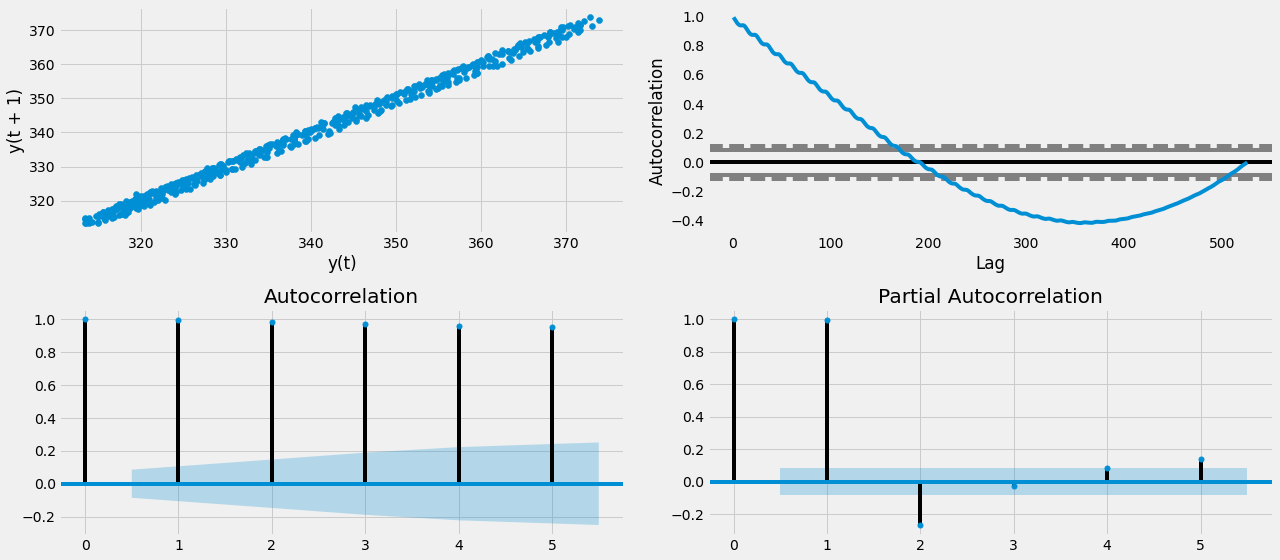

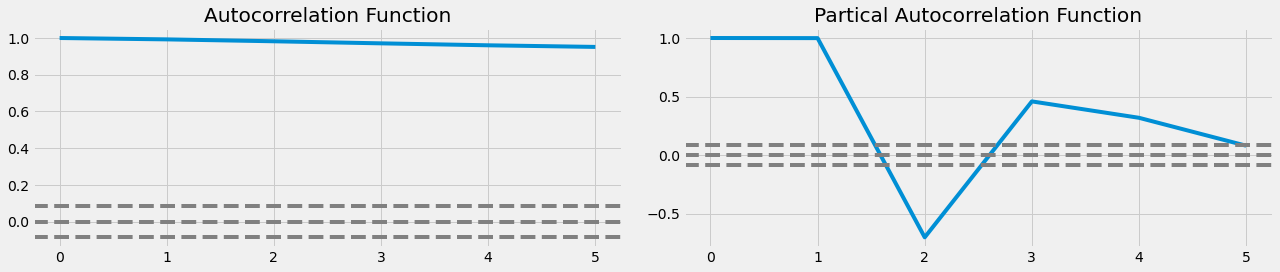

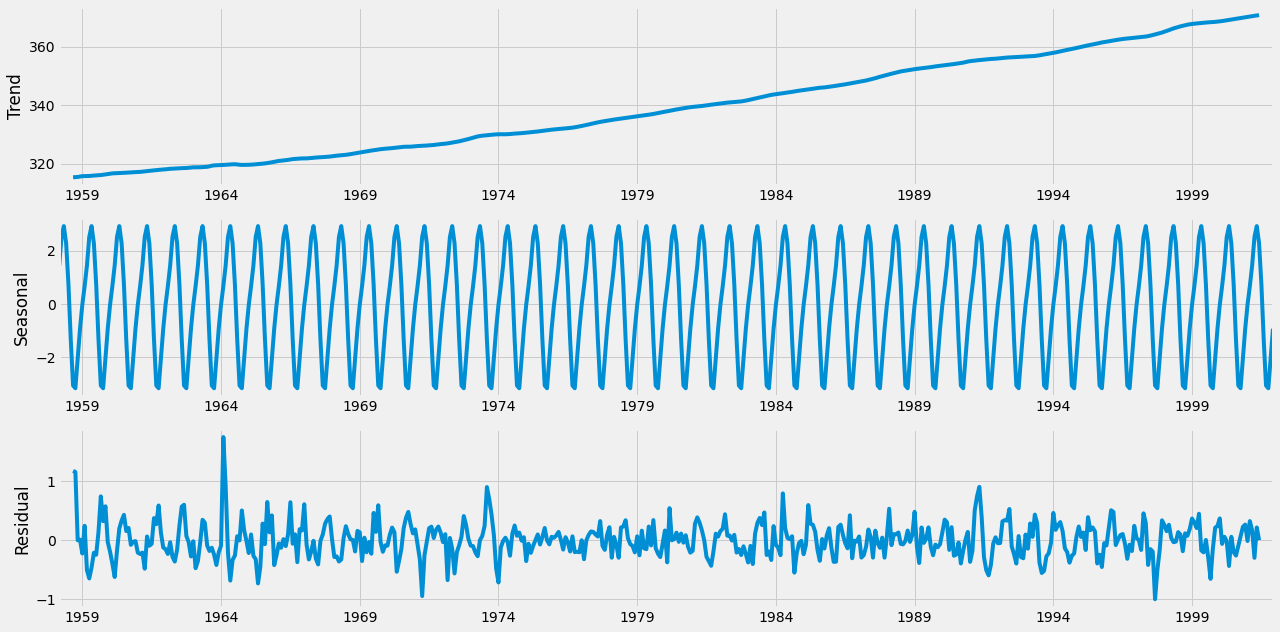

In [57]:
plot_lags_autocorrelation_acf_pacf(s, 5)
plot_calculated_acf_and_pacf(s, 5)
plot_seasonal_decomposition(s, model='additive')

## 3. Forecast
### 3.1 Grid Search for ARIMA parameters
* ARIMA 的參數是 $p$, $d$, $q$，寫成 ARIMA($p$, $d$, $q$)
* seasonal ARIMA 的參數是 $p$, $d$, $q$, $P$, $D$, $Q$, $S$，寫成 ARIMA($p$, $d$, $q$)($P$, $D$, $Q$, $S$)
  * Non-seasonal components 用 ($p$, $d$, $q$)
  * Seasonal components 用 ($P$, $D$, $Q$, $S$)
    * $S$ 表示週期性，例如 quarterly $S = 4$, monthly $S = 12$
* 使用 $p$, $d$, $q$, $P$, $D$, $Q$, $S$ 這些參數的組合來找出最合適的參數
  * Akaike Information Criterion (AIC) 是參數好壞的選擇標準
    * AIC 的值越小越好 

In [58]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2) # 不包含 2

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q)) # 得到各種 p, d, q 的可能的組合
print(pdq)

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print(seasonal_pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [59]:
print('Examples of parameter combinations for Seasonal ARIMA...')
# 不需要 pdq[0]=(0, 0, 0) 和 seasonal_pdq[0]=(0, 0, 0, 12) 因為都是 0
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
print("and more...")

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
and more...


In [60]:
def grid_search(time_series, pdq, seasonal_pdq):
  # specify to ignore warning messages
  warnings.filterwarnings("ignore")

  best_pdq = None
  best_seasonal_pdq = None
  best_aic = float("inf")

  for param in pdq:
    for param_seasonal in seasonal_pdq:
      try:
        model = sm.tsa.statespace.SARIMAX(time_series,
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        results = model.fit()
        aic = results.aic
        print(f"ARIMA{param}{param_seasonal}: AIC={aic}")

        if aic < best_aic:
          best_aic = aic
          best_pdq = param
          best_seasonal_pdq = param_seasonal
      except:
        continue

  print(f"The best model is ARIMA{best_pdq}{best_seasonal_pdq}: AIC={best_aic}")

In [61]:
grid_search(s, pdq, seasonal_pdq)

ARIMA(0, 0, 0)(0, 0, 0, 12): AIC=7612.583429881011
ARIMA(0, 0, 0)(0, 0, 1, 12): AIC=6787.343624030624
ARIMA(0, 0, 0)(0, 1, 0, 12): AIC=1854.828234141261
ARIMA(0, 0, 0)(0, 1, 1, 12): AIC=1596.711172763787
ARIMA(0, 0, 0)(1, 0, 0, 12): AIC=1058.9388921320035
ARIMA(0, 0, 0)(1, 0, 1, 12): AIC=1056.2878436717715
ARIMA(0, 0, 0)(1, 1, 0, 12): AIC=1361.6578977746117
ARIMA(0, 0, 0)(1, 1, 1, 12): AIC=1044.7647912939685
ARIMA(0, 0, 1)(0, 0, 0, 12): AIC=6881.048754229354
ARIMA(0, 0, 1)(0, 0, 1, 12): AIC=6072.662327715852
ARIMA(0, 0, 1)(0, 1, 0, 12): AIC=1379.1941066935976
ARIMA(0, 0, 1)(0, 1, 1, 12): AIC=1241.417471681812
ARIMA(0, 0, 1)(1, 0, 0, 12): AIC=1085.52473663032
ARIMA(0, 0, 1)(1, 0, 1, 12): AIC=851.7114599176633
ARIMA(0, 0, 1)(1, 1, 0, 12): AIC=1119.5957893608688
ARIMA(0, 0, 1)(1, 1, 1, 12): AIC=807.0912988348939
ARIMA(0, 1, 0)(0, 0, 0, 12): AIC=1675.8086923024293
ARIMA(0, 1, 0)(0, 0, 1, 12): AIC=1240.2211199194085
ARIMA(0, 1, 0)(0, 1, 0, 12): AIC=633.442558698737
ARIMA(0, 1, 0)(0, 1, 1, 1

### 3.2 Fitting the ARIMA model

In [62]:
model = sm.tsa.statespace.SARIMAX(s,
                                  order=(1, 1, 1),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

results = model.fit()

print(results.summary()) # 看全部的表格
# print(results.summary().tables[1]) # 只看係數的表格

                                 Statespace Model Results                                 
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -133.890
Date:                            Fri, 11 Sep 2020   AIC                            277.780
Time:                                    00:39:02   BIC                            298.843
Sample:                                03-01-1958   HQIC                           286.046
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3185      0.092      3.448      0.001       0.137       0.500
ma.L1         -0.6259      0.077   

* 只看係數的表格會發現所有的係數的 $p$-value 都 < 0.05 或是很接近 0.05，這表示這些係數都很重要
* SARIMAX 提供了 `plot_diagnostics()` 可以用來看 model diagnostic 檢查結果是否有不正常的行為
  * Residual 必須是 N(0, 1) 分佈，且沒有 correlation
    * 分佈看右上 (是否是常態分佈) 和左下圖
    * 有沒有 correlation 看左上 (是否是 white noise) 和右下圖 (有無 autocorrelation)

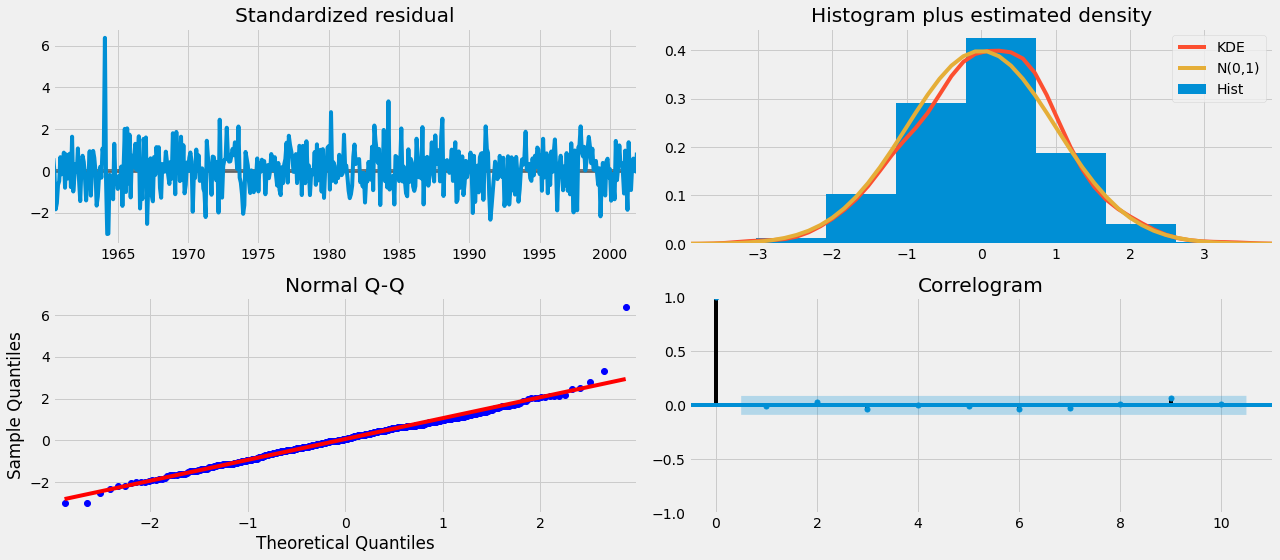

In [63]:
results.plot_diagnostics(figsize=(18, 8))
plt.tight_layout()
plt.show()

### 3.3 Validating forecasts
* one-step ahead forecasts: 就是用過去的資料來預測下一個資料點，一次只預測一個點，直到 testing sample 的資料點全部都預測完
  * history data + $y(t)$ 來求 $\hat{y}(t+1)$
* Dynamic forecast: 一樣一次只預測一個點，直到 testing sample 的資料點全部都預測完，但是未來的資料點是用 forecast 的
  * history data + $\hat{y}(t)$ 來求 $\hat{y}(t+1)$

#### 3.3.1 使用 One-step ahead forecasts

In [64]:
# 預測 time series 中，日期是 1998-01-01 之後的結果
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'),
                              dynamic=False) # dynamic=False 表示用 one-step ahead forecasts
pred_ci = pred.conf_int() # conf_int() 是 confidence interval

In [65]:
type(pred)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [66]:
pred_ci # 是預測的結果的範圍

,lower co2,upper co2
1998-01-01,364.453332,365.675162
1998-02-01,365.373381,366.595210
1998-03-01,366.404552,367.626382
1998-04-01,367.908384,369.130212
1998-05-01,368.389369,369.611197
1998-06-01,367.802323,369.024150
1998-07-01,366.481823,367.703651
1998-08-01,364.754046,365.975874
1998-09-01,363.199734,364.421562
1998-10-01,363.378375,364.600203


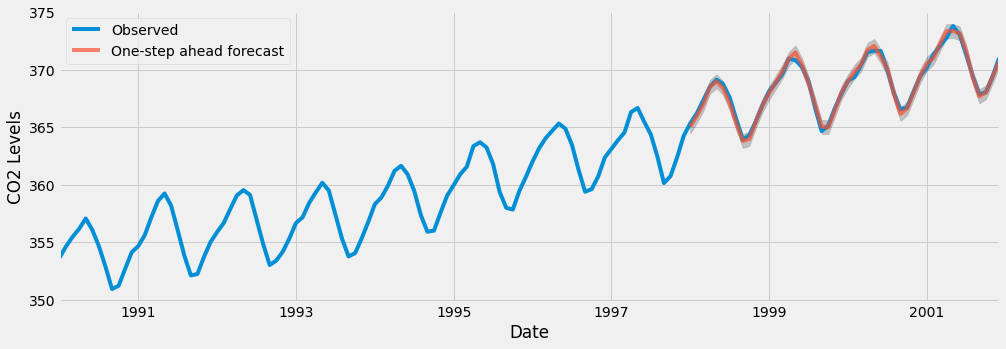

In [67]:
ax = s['1990':].plot(label='Observed', figsize=(15, 5))
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

#### 計算 Metrics

In [68]:
y_forecasted = pred.predicted_mean
y_truth = s['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {round(mse, 2)}')

The Mean Squared Error of our forecasts is 0.07


In [69]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_truth, y_forecasted)
print(mse)

0.07303141392445038


* 用 sklearn 的 mean_squared_error 和自己手算的 mse 有一點點差別

 #### 3.3.2 使用 dynamic forecasts

In [70]:
# 使用 dynamic forecasts
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), 
                                      dynamic=True, # 這邊用 true 就是要用 dynamic forecast
                                      full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [71]:
pred_dynamic_ci

,lower co2,upper co2
1998-01-01,364.453332,365.675162
1998-02-01,365.050137,366.536447
1998-03-01,365.874825,367.529274
1998-04-01,367.090550,368.882576
1998-05-01,367.550539,369.465989
1998-06-01,366.824176,368.854279
1998-07-01,365.234737,367.372968
1998-08-01,363.143025,365.384057
1998-09-01,361.355695,363.694978
1998-10-01,361.462510,363.896069


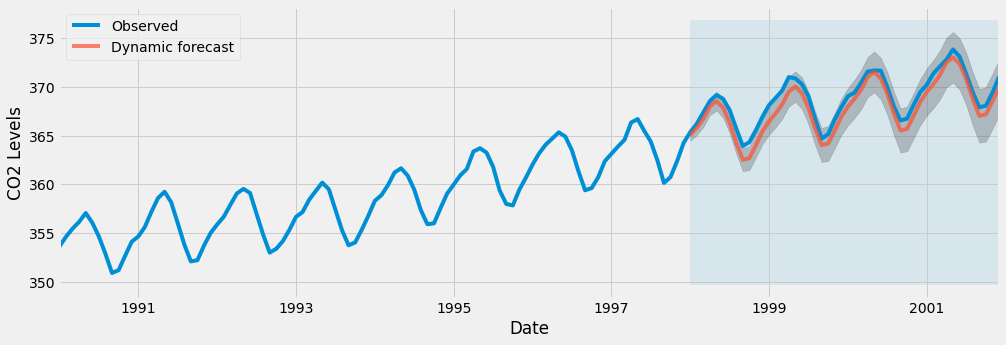

In [72]:
ax = s['1990':].plot(label='Observed', figsize=(15, 5))
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic forecast', alpha=.7)
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), s.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

#### 計算 Metrics

In [73]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = s['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {round(mse, 2)}')

The Mean Squared Error of our forecasts is 1.01


In [74]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_truth, y_forecasted)
print(mse)

1.010077940149638


### 3.4 Forecast future
* `get_prediction()` 是藉由指定日期，來預測 test sample 部分的結果，因為 time series 在建 model 時就提供了，所以只要指定用哪一天來當作要預測的起始日期
* `get_forecast()` 是利用建好的 model 來預測未知的部分，所以是指定要預測幾個 time steps

In [75]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [76]:
pred_ci

,lower co2,upper co2
2002-01-01,371.366747,372.588572
2002-02-01,372.005932,373.492237
2002-03-01,372.835016,374.489460
2002-04-01,373.963471,375.755492
2002-05-01,374.387865,376.303308
...,...,...
2043-04-01,410.881414,467.644272
2043-05-01,411.295085,468.203313
2043-06-01,410.645856,467.699049
2043-07-01,409.053211,466.250992


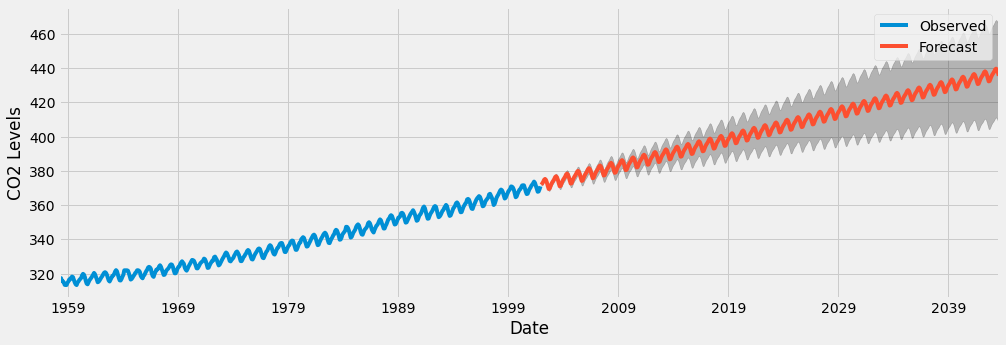

In [77]:
ax = s.plot(label='Observed', figsize=(15, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()